# Liver tumour Classification using a Convolutional Neural Network

This notebook contains the full pipeline for training and evaluating a
deep learning model to classify liver ultrasound images as Benign, Malignant, or Normal.

## Setup

### Main imports and device checking

In [35]:
import torch
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [36]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [37]:
pip show torch

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\Users\James\py311-env\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [38]:
print("CUDA Available:", torch.cuda.is_available())
print(
    "CUDA Device Name:",
    torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU",
)

CUDA Available: True
CUDA Device Name: NVIDIA GeForce GTX 970


In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Loading and Transforming the Data

To my surprise there was better performance on the train and validation sets without flipping and rotation in the transform despite the small size of the dataset. For that reason I've gone with the basic transforms for a CNN here.

In [40]:
# Standard image transformations for a pre-trained ImageNet model:
# resize, convert to tensor, and normalise to [-1, 1].
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [41]:
%run src\\data_utils.py

Train size: 529
Validation size: 59
Test size: 147


Not much data in that Validation set.

In [42]:
print(train_data["label"].value_counts())
print(val_data["label"].value_counts())
print(test_data["label"].value_counts())
print(train_val["label"].value_counts())

label
Malignant    313
Benign       144
Normal        72
Name: count, dtype: int64
label
Malignant    35
Benign       16
Normal        8
Name: count, dtype: int64
label
Malignant    87
Benign       40
Normal       20
Name: count, dtype: int64
label
Malignant    348
Benign       160
Normal        80
Name: count, dtype: int64


There's a good spread for each category across each set. It's concerning however that there's such a low amount of each category in the validation set.

In [43]:
train_data

,image_path,label
484,C:\Users\James\Documents\Portfolio\liver-ultra...,Malignant
218,C:\Users\James\Documents\Portfolio\liver-ultra...,Malignant
148,C:\Users\James\Documents\Portfolio\liver-ultra...,Benign
173,C:\Users\James\Documents\Portfolio\liver-ultra...,Benign
641,C:\Users\James\Documents\Portfolio\liver-ultra...,Normal
...,...,...
464,C:\Users\James\Documents\Portfolio\liver-ultra...,Malignant
264,C:\Users\James\Documents\Portfolio\liver-ultra...,Malignant
230,C:\Users\James\Documents\Portfolio\liver-ultra...,Malignant
710,C:\Users\James\Documents\Portfolio\liver-ultra...,Normal


In [44]:
from torch.utils.data import Dataset
from PIL import Image


class LiverDataset(Dataset):
    """
    A custom PyTorch Dataset for loading liver scan images and their corresponding labels.

    This dataset expects a Pandas DataFrame with 'image_path' and 'label' columns.
    It maps string labels ("Benign", "Malignant", "Normal") to numerical values (0, 1, 2).
    Images are loaded using PIL and can be optionally transformed.
    """

    def __init__(self, dataframe, transform=None):
        """
        Initializes the LiverDataset.

        Args:
            dataframe (pd.DataFrame): A Pandas DataFrame containing image paths and labels.
                                      Expected columns are 'image_path' and 'label'.
            transform (callable, optional): A function/transform to be applied to the images.
                                            Defaults to None.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"Benign": 0, "Malignant": 1, "Normal": 2}

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label from the dataset at the given index.

        The image is loaded from the specified path, converted to RGB, and then
        the transforms are performed. The label is mapped from its string representation to 
        a numerical value.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - image (torch.Tensor or PIL.Image.Image): The loaded and transformed image.
                - label (int): The numerical label corresponding to the image.
        """
        img_path = self.data.loc[idx, "image_path"]
        label = self.label_map[self.data.loc[idx, "label"]]

        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)

        return image, label

In [45]:
BATCH_SIZE = 32

In [46]:
from torch.utils.data import DataLoader

# Initializes custom 'LiverDataset' objects from pre-split DataFrames (train_val, val_data, test_data)
# and applies the defined image 'transform'. These datasets are then wrapped in DataLoaders
# to manage batching, shuffling (for training), and efficient data loading for
# model training, validation, and final testing.

# Note on train_data: The 'train_val' split is used here as the primary training set
# after model hyperparameter tuning is complete, leveraging more data for final training.

train_data = LiverDataset(train_val, transform=transform)
val_data = LiverDataset(val_data, transform=transform)
test_data = LiverDataset(test_data, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [47]:
train_data

In [48]:
class_names = ["Benign", "Malignant", "Normal"]

## Building the CNN

### Preparing the Layers and Training Loop

The network contains two convolutional layers followed by ReLU, max-pooling,
and three fully connected layers. Dropout and batch normalization are used
to prevent overfitting.

In [49]:
import torch.nn as nn
import torch.nn.functional as F


class NeuralNet(nn.Module):
    """
    A Convolutional Neural Network (CNN) for image classification.

    This network consists of two convolutional layers followed by max-pooling,
    batch normalisation, and ReLU activations. The features are then flattened
    and passed through three fully connected layers with dropout for regularisation.
    The final layer outputs scores for 3 classes.

    Assumes input images are of size (Batch_Size, 3, 224, 224).
    """

    def __init__(self):
        """
        Initialises the layers of the NeuralNet.
        """
        super().__init__()

        # Convolutional Block 1
        # Input: (Batch_Size, 3, 224, 224) - assuming standard RGB image
        # After Conv1: (Batch_Size, 12, 220, 220) - formula: (H_in - K_H + 2P_H)/S_H + 1
        # H_in=224, K_H=5, P_H=0, S_H=1 => (224 - 5 + 0)/1 + 1 = 220
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(num_features=12) # Normalises outputs of conv1

        # Max Pooling layer - reduces spatial dimensions by half
        # After Pool: (Batch_Size, 12, 110, 110)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 2
        # Input: (Batch_Size, 12, 110, 110) - from previous pooling
        # After Conv2: (Batch_Size, 24, 106, 106) - formula: (110 - 5 + 0)/1 + 1 = 106
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=24) # Normalises outputs of conv2

        # Calculate the flattened size after the convolutional and pooling layers.
        # After the second pooling, the feature map size will be (24, 53, 53).
        # H_after_pool1 = 220 / 2 = 110
        # H_after_conv2 = 110 - 5 + 1 = 106
        # H_after_pool2 = 106 / 2 = 53
        self.fc1 = nn.Linear(in_features=24 * 53 * 53, out_features=120)
        self.dropout1 = nn.Dropout(p=0.3) # Dropout for regularisation, prevents overfitting

        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.dropout2 = nn.Dropout(p=0.3) # Another dropout layer

        self.fc3 = nn.Linear(in_features=84, out_features=3) # Output layer for 3 classes

    def forward(self, x):
        """
        Defines the forward pass of the NeuralNet.

        Args:
            x (torch.Tensor): The input tensor, expected to be of shape
                              (Batch_Size, 3, H, W), typically (Batch_Size, 3, 224, 224).

        Returns:
            torch.Tensor: The output tensor with raw scores for each of the 3 classes.
                          Shape: (Batch_Size, 3).
        """
        # Convolutional Block 1: Conv -> BatchNorm -> ReLU -> MaxPool
        # Input: (B, 3, 224, 224) -> Output: (B, 12, 110, 110)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Convolutional Block 2: Conv -> BatchNorm -> ReLU -> MaxPool
        # Input: (B, 12, 110, 110) -> Output: (B, 24, 53, 53)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Flatten the feature map from (Batch_Size, Channels, Height, Width)
        # to (Batch_Size, Channels * Height * Width) for the fully connected layers.
        x = torch.flatten(x, 1) # Start flattening from dimension 1 (channel dimension)

        # Fully Connected Layer 1: Linear -> ReLU -> Dropout
        x = self.dropout1(F.relu(self.fc1(x)))

        # Fully Connected Layer 2: Linear -> ReLU -> Dropout
        x = self.dropout2(F.relu(self.fc2(x)))

        # Fully Connected Layer 3 (Output Layer): Linear
        # No activation function here, as this typically outputs logits/raw scores
        # for classification, which are then passed to a loss function like CrossEntropyLoss.
        x = self.fc3(x)
        return x

Have also experimented with SGD (Stochastic Gradient Descent) and a few other lr (learning rate) values and found Adam with 0.0005 was optimal here.

In [50]:
# Initialises the neural network model, moves it to the specified device (CPU/GPU),
# defines the Cross-Entropy Loss for multi-class classification, and sets up
# the Adam optimiser with a learning rate of 0.0005 and L2 regularisation (weight decay)
# of 1e-5 to update the model's parameters during training.

net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=1e-5)

Due to having older hardware I implemented an early stopping function for when the validation loss is no longer decreasing as 30 epoch training usually takes around 3-4 minutes which at the end isn't a big deal but for tuning hyperparameters it saves a lot of time.

In [51]:
import numpy as np


class EarlyStopping:
    """
    Implements an early stopping mechanism to halt training when a monitored
    validation metric (e.g., validation loss) stops improving.

    This helps to prevent overfitting by saving the model state corresponding
    to the best observed validation performance.

    Attributes:
        patience (int):
            How many epochs to wait for improvement before stopping.
        verbose (bool):
            If True, prints a message for each counter increment and when
            the best model is saved.
        path (str):
            File path where the best model's state_dict will be saved.
        counter (int):
            Internal counter to track epochs without improvement.
        best_loss (float):
            Stores the minimum validation loss observed so far. Initialised to infinity.
        early_stop (bool):
            Flag set to True when training should be stopped.
    """

    def __init__(self, patience=5, verbose=False, path="models\\best_model.pth"):
        """
        Initialises the EarlyStopping instance.

        Args:
            patience (int, optional):
                Number of epochs with no improvement after which training will be stopped.
                Defaults to 5.
            verbose (bool, optional):
                If True, prints messages about early stopping progress and model saving.
                Defaults to False.
            path (str, optional):
                Filename (including path) where the best model's state_dict will be saved.
                Defaults to "best_model.pth".
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf  # Initialise with positive infinity
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        """
        Updates the early stopping state based on the current validation loss.

        This method should be called after each epoch's validation phase.
        It checks if the validation loss has improved. If it has, the best
        loss is updated, the counter is reset, and the current model state
        is saved. If not, the counter is incremented, and if it reaches
        'patience', the 'early_stop' flag is set to True.

        Args:
            val_loss (float):
                The validation loss obtained in the current epoch.
            model (torch.nn.Module):
                The PyTorch model whose state_dict should be saved if
                a new best validation loss is observed.
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True # Set flag to stop training

    def save_checkpoint(self, model):
        """
        Saves the current state_dict of the model to the specified path.

        This method is called internally when a new best validation loss is achieved.

        Args:
            model (torch.nn.Module):
                The PyTorch model whose state_dict is to be saved.
        """

        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f}). Saving model to {self.path}")

In [52]:
def evaluate_model(net, data_loader, criterion, device):
    """
    Evaluates the model on the given data loader.

    Args:
        net (torch.nn.Module): The neural network model.
        data_loader (torch.utils.data.DataLoader): The data loader (e.g., val_loader or test_loader).
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device to run the evaluation on (e.g., 'cpu' or 'cuda').

    Returns:
        tuple: A tuple containing the average loss, accuracy,
               a list of all predictions, and a list of all true labels.
    """
    net.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Convert predicted and true labels to CPU and then to NumPy arrays
            # Then extend the Python lists
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples

    return avg_loss, accuracy, all_preds, all_labels

## Running the CNN on the Data

### Training on the Train Set and Testing on the Validation Set

In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


# This section defines key training hyperparameters and initialises the
# model, loss function, optimiser, learning rate scheduler, and early stopping
# mechanism, preparing the environment for the training process.

epochs = 30  # Total number of training epochs to run.
net = NeuralNet().to(device) # Initialises the custom neural network model and moves it to the specified device (CPU/GPU).
criterion = nn.CrossEntropyLoss() # Defines the loss function, Cross-Entropy Loss, suitable for multi-class classification.
optimizer = optim.Adam(net.parameters(), lr=0.0005) # Initialises the Adam optimiser to update model weights with a learning rate of 0.0005.

# The scheduler reduces the learning rate when the validation loss stops improving.
# - optimiser: The optimiser whose learning rate will be adjusted.
# - mode='min': Monitors a metric that should be minimised (here, validation loss).
# - patience=3: After 3 epochs with no improvement, the learning rate will be reduced.
# - factor=0.5: The learning rate will be multiplied by 0.5 (halved) when reduced.
# - verbose=True: Prints a message when the learning rate is adjusted.
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.5, verbose=True
)

# This halts training if validation loss doesn't improve for a set number of epochs.
# - patience=5: Allows up to 5 epochs without improvement before stopping.
# - verbose=True: Prints messages related to early stopping progress.
early_stopping = EarlyStopping(patience=5, verbose=True)


# The following code is the training and validation loop
# It iterates through the specified number of epochs, performing training,
# validation, and updating model components (optimiser, scheduler, early stopping).

for epoch in range(epochs):
    net.train()  # Set the model to training mode (e.g., enables dropout, BatchNorm updates).
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase: Iterate over the training (and validation) dataset
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move data to the specified device.
        optimizer.zero_grad()  # Reset gradients from the previous iteration.
        outputs = net(inputs)  # Forward pass: compute model outputs.
        loss = criterion(outputs, labels) # Calculate the loss.
        loss.backward()  # Backward pass: compute gradients.
        optimizer.step()  # Update model parameters using the optimiser.

        train_loss += loss.item() * labels.size(0) # Accumulate batch loss.
        _, predicted = torch.max(outputs, 1) # Get the index of the max log-probability as the prediction.
        correct_train += (predicted == labels).sum().item() # Count correct predictions.
        total_train += labels.size(0) # Accumulate total samples.

    avg_train_loss = train_loss / total_train # Calculate average training loss for the epoch.
    train_acc = 100 * correct_train / total_train # Calculate training accuracy for the epoch.

    # Validation phase: Evaluate the model on just the validation set.
    # Assumes 'evaluate_model' function returns average validation loss, accuracy, predictions, and labels.
    avg_val_loss, val_acc, val_preds, val_labels = evaluate_model(net, val_loader, criterion, device)

    # Print epoch summary
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

    # Step the learning rate scheduler: Adjusts LR based on validation loss.
    scheduler.step(avg_val_loss)

    # Step the early stopping mechanism: Checks if training should be halted.
    # It also handles saving the best model based on validation loss.
    early_stopping(avg_val_loss, net)

    # Check if early stopping condition is met
    if early_stopping.early_stop:
        print("Early stopping triggered. Training halted.")
        break # Exit the training loop

c:\Users\James\py311-env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 1.5926, Train Acc: 47.79% | Val Loss: 0.8239, Val Acc: 67.80%
Validation loss decreased (0.823875). Saving model to models\best_model.pth
Epoch 2/30 | Train Loss: 0.9786, Train Acc: 59.69% | Val Loss: 0.7071, Val Acc: 66.10%
Validation loss decreased (0.707127). Saving model to models\best_model.pth
Epoch 3/30 | Train Loss: 0.7969, Train Acc: 62.24% | Val Loss: 0.6779, Val Acc: 76.27%
Validation loss decreased (0.677872). Saving model to models\best_model.pth
Epoch 4/30 | Train Loss: 0.7353, Train Acc: 64.80% | Val Loss: 0.6111, Val Acc: 71.19%
Validation loss decreased (0.611083). Saving model to models\best_model.pth
Epoch 5/30 | Train Loss: 0.6792, Train Acc: 69.39% | Val Loss: 0.5654, Val Acc: 74.58%
Validation loss decreased (0.565401). Saving model to models\best_model.pth
Epoch 6/30 | Train Loss: 0.6692, Train Acc: 71.09% | Val Loss: 0.6255, Val Acc: 69.49%
EarlyStopping counter: 1 out of 5
Epoch 7/30 | Train Loss: 0.6257, Train Acc: 70.41% | Val Loss: 0

### Saving and Loading the Best Model

In [54]:
# Initializes a new model instance, loads the previously saved "best" weights
# (typically from the epoch with the lowest validation loss), and sets the
# model to evaluation mode. This prepares the model for unbiased inference,
# disabling training-specific behaviors like Dropout and BatchNorm updates.

best_model = NeuralNet().to(device)
best_model.load_state_dict(torch.load("models\\best_model.pth"))
best_model.eval()

C:\Users\James\AppData\Local\Temp\ipykernel_19384\2085768746.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("models\\best_model.pt

NeuralNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=67416, out_features=120, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [55]:
# Readying our network using the best model for the next step
net = NeuralNet()
net.load_state_dict(torch.load("models\\best_model.pth"))

C:\Users\James\AppData\Local\Temp\ipykernel_19384\2348888272.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("models\\best_model.pth"))


<All keys matched successfully>

### Examining our Best Model's Performance on the Validation Set

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def matrix_vis(labels, preds, set_name):
    """
    Generates and displays a confusion matrix for classification results,
    along with per-class accuracy.

    This function calculates the confusion matrix, plots it using a 'Blues' colourmap,
    adds a title indicating the dataset it represents, and then computes and prints
    the accuracy for each individual class.

    Args:
        labels (array-like):
            True labels (ground truth) for the samples.
            Expected to be 1D array or list of numeric class IDs.
        preds (array-like):
            Predicted labels for the samples from the model.
            Expected to be 1D array or list of numeric class IDs.
        set_name (str):
            A descriptive string indicating the dataset being evaluated
            (e.g., "Validation", "Test"). Used in the plot title.

    Returns:
        None:
            This function displays a plot and prints to console; it does not
            return any value.
    """
    # Calculate the confusion matrix based on true and predicted labels.
    cm = confusion_matrix(labels, preds)

    # Create a ConfusionMatrixDisplay object for plotting.
    # 'class_names' is assumed to be a global variable or accessible in this scope,
    # containing the string names for each class in the correct order.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with a 'Blues' colormap.
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix on {set_name} Set") # Set the plot title.
    plt.show() # Display the plot.

    # Calculate per-class accuracy
    cm_sum = cm.sum(axis=1, keepdims=True) # Sum of each row (total true instances for each class).
    class_acc = (cm.diagonal() / cm_sum.flatten()) * 100 # Diagonal elements (correct predictions) / row sum.

    # Print accuracy for each class
    for name, acc in zip(class_names, class_acc):
        print(f"{name} Accuracy: {acc:.2f}%")

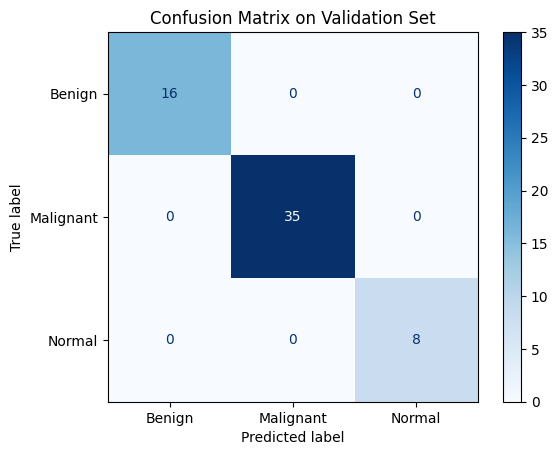

Benign Accuracy: 100.00%
Malignant Accuracy: 100.00%
Normal Accuracy: 100.00%


In [57]:
matrix_vis(val_labels, val_preds, set_name="Validation")

Overfitting here was expected as the dataset that was used for training was a combined set of both train plus validation. Just as a reminder it was done as a last resort due to k-Fold Cross Validation not improving the performance, so the smallness of the validation set had to be tackled somehow.

### Tested on Images from Outside the Dataset

In [58]:
def load_image(image_path):
    """
    Loads a single image from the specified path, preprocesses it,
    and prepares it for input into a PyTorch model.

    This function performs the following steps:
    1. Opens the image using Pillow (PIL.Image.open).
    2. Converts the image to RGB format to ensure consistent channel order.
    3. Applies a predefined 'transform' pipeline (e.g., resizing, converting to tensor, normalisation).
    4. Adds an extra dimension to the tensor (unsqueeze(0)) to represent the batch size.
       This is necessary because models typically expect input in the format (Batch_Size, Channels, Height, Width),
       even for a single image.

    Args:
        image_path (str):
            The file path to the image to be loaded.

    Returns:
        torch.Tensor:
            A preprocessed image tensor ready for model inference, with a batch dimension.
    """
    image = Image.open(image_path).convert("RGB") # Load image and ensure it's in RGB format.
    image = transform(image) # Apply the predefined transformation pipeline (e.g., resize, to_tensor, normalise).
    image = image.unsqueeze(0) # Add a batch dimension (e.g., from [C, H, W] to [1, C, H, W]).
    return image


# This section demonstrates how to use the trained model to make predictions
# on a small set of 'outside' images not included in the original dataset splits.
# This helps to visualise the model's performance on new, unseen examples.

# Define paths to selected images for prediction. These images should be external
# to the training/validation/test sets and ideally diverse.
image_paths = ["b1.jpg", "b2.jpg", "m1.jpg", "m2.jpg", "n1.jpg", "n2.jpg"]

# Load and preprocess each image using the 'load_image' utility function.
images = [load_image("demo_images\\"+img_path) for img_path in image_paths]

# Create an iterator for the actual (true) labels of these external images.
# This allows 'next(actual)' to retrieve the correct label sequentially for printing.
actual = iter(["Benign", "Benign", "Malignant", "Malignant", "Normal", "Normal"])


net.eval() # Set the model to evaluation mode. This disables layers like Dropout and ensures BatchNorm uses learned statistics.
with torch.no_grad(): # Disable gradient calculations.
    # This reduces memory consumption and speeds up computation during inference,
    # as gradients are not needed for predictions.
    for image in images:
        output = net(image) # Perform a forward pass to get raw model outputs (logits).
        _, predicted = torch.max(output, 1) # Get the class with the highest probability/logit as the prediction.
                                            # 'predicted' is a tensor, .item() extracts the scalar value.
        # Print the actual label (from the iterator) and the model's predicted class name.
        print(f"Actual: {next(actual)} | Prediction: {class_names[predicted.item()]}")

Actual: Benign | Prediction: Malignant
Actual: Benign | Prediction: Benign
Actual: Malignant | Prediction: Benign
Actual: Malignant | Prediction: Malignant
Actual: Normal | Prediction: Malignant
Actual: Normal | Prediction: Benign


It was quite difficult to gather 6 images from the web that don't have display information or patient and machine data. Furthermore it was difficult to find ultrasound images that were labeled with a category. In most of my runs of the model during the training phase the benign and malignant images seem to be correctly predicted but never the normal liver images. This isn't completely unexpected as there are far fewer 'Normal' images than the other two categories (100 out of 735). It's also not a huge deal as it's a bigger deal to catch a malignant tumor than misclassify a normal liver.

## Best Model on the Test Set

In [59]:
net = net.to(device)

In [60]:
avg_test_loss, test_acc, test_preds, test_labels = evaluate_model(net, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {avg_test_loss:.4f}")

Test Accuracy: 78.23%
Test Loss: 0.7269


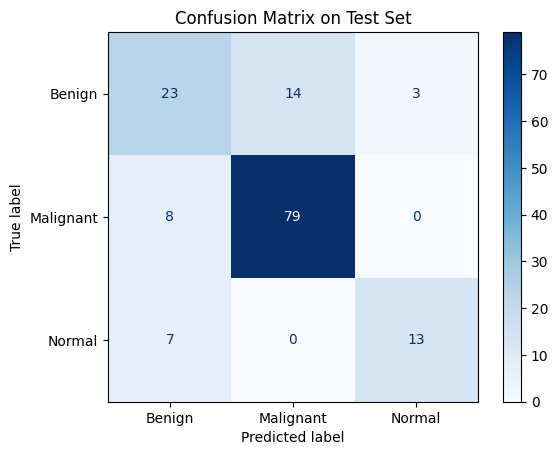

Benign Accuracy: 57.50%
Malignant Accuracy: 90.80%
Normal Accuracy: 65.00%


In [61]:
matrix_vis(test_labels, test_preds, set_name="Test")

The outcome which would cause most concern would be classifying a malignant tumour as benign (position [1, 0] in the matrix). In my test there are 8 (5.4% of the test data) examples of this. In real life situations further diagnostic tests are typically performed to classify the tumour correctly, and they would need to be if using this model.

Let's get a classification report of these results to look a little deeper.

In [62]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Individual metrics (weighted average)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1 Score:  {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

      Benign       0.61      0.57      0.59        40
   Malignant       0.85      0.91      0.88        87
      Normal       0.81      0.65      0.72        20

    accuracy                           0.78       147
   macro avg       0.76      0.71      0.73       147
weighted avg       0.78      0.78      0.78       147

Weighted Precision: 0.7780
Weighted Recall:    0.7823
Weighted F1 Score:  0.7782


Most importantly the malignant cases have both high precision and recall which is a priority in medical applications. Normal cases are performing well and benign cases are performing weaker. As seen in the confusion matrix the model often confuses benign cases as malignant which is likely due to class imbalance (most of the images are of malignant cases).